# 7. gRNA-mRNA Interaction Analysis: Mechanistic Insights into Classification Errors

## Abstract

Guide RNAs (gRNAs) in *Trypanosoma brucei* direct the insertion and deletion of uridine residues in mitochondrial mRNA transcripts through a complex base-pairing mechanism. This notebook investigates whether the **thermodynamic properties of gRNA-mRNA interactions** can explain classifier errors—specifically, why certain sequences are misclassified as gRNA (False Positives) or missed entirely (False Negatives).

We employ **RNA duplex folding** (ViennaRNA) to predict interaction energies between candidate gRNA sequences and their putative mRNA targets, providing mechanistic context that complements sequence-based feature analysis.

---

## Background

### The RNA Editing Mechanism

gRNAs guide RNA editing through three functional domains:

1. **Anchor region** (positions ~6-16): Base-pairs with pre-edited mRNA to position the editing complex
2. **Guiding region**: Provides template for U-insertion/deletion
3. **Oligo-U tail**: Stabilizes gRNA-mRNA interaction

### Hypothesis

We hypothesize that:
- **True gRNAs** will show strong, specific binding to their cognate mRNA targets
- **False Positives** may either:
  - Show spurious binding to mRNAs (explaining misclassification)
  - Lack specific targets (suggesting they are truly non-functional)
- **False Negatives** may have unusual binding properties that obscure their gRNA nature

---

In [1]:
# =============================================================================
# IMPORTS AND CONFIGURATION
# =============================================================================

import warnings
import json
import re
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle, FancyBboxPatch, ConnectionPatch
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import joblib

# ViennaRNA for RNA-RNA interaction prediction
try:
    import RNA
    VIENNARNA_AVAILABLE = True
    print(f"✓ ViennaRNA {RNA.__version__}")
except ImportError:
    VIENNARNA_AVAILABLE = False
    print("✗ ViennaRNA not available")

warnings.filterwarnings('ignore')

# Publication-quality plotting
plt.rcParams.update({
    'figure.dpi': 150,
    'figure.figsize': (12, 8),
    'font.size': 10,
    'font.family': 'sans-serif',
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'axes.titleweight': 'bold',
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
})
sns.set_style('whitegrid')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Color palette for prediction types
COLORS = {
    'True Positive': '#27ae60',   # Green
    'True Negative': '#3498db',   # Blue
    'False Positive': '#e74c3c',  # Red
    'False Negative': '#f39c12',  # Orange
    'gRNA': '#27ae60',
    'non-gRNA': '#3498db',
    'anchor': '#e74c3c',
    'guide': '#3498db',
    'mRNA': '#9b59b6'
}

print("\nConfiguration complete")

✓ ViennaRNA 2.7.1

Configuration complete


In [2]:
# =============================================================================
# PATH CONFIGURATION
# =============================================================================

# Data paths - adjust as needed
POSSIBLE_PATHS = [
    Path.home() / 'projects' / 'grna-inspector',
    Path('/mnt/user-data/uploads'),
    Path('/mnt/project'),
    Path('.')
]

BASE_DIR = None
DATA_DIR = None
MODELS_DIR = None
MRNA_DIR = None

for path in POSSIBLE_PATHS:
    if (path / 'data' / 'processed' / 'v3_pipeline' / 'train_data.csv').exists():
        BASE_DIR = path
        DATA_DIR = path / 'data' / 'processed' / 'v3_pipeline'
        MODELS_DIR = path / 'models'
        MRNA_DIR = path / 'data' / 'maxicircles'
        break
    elif (path / 'train_data.csv').exists():
        BASE_DIR = path
        DATA_DIR = path
        MODELS_DIR = path
        break

# Also check for transcripts in project directory
TRANSCRIPTS_FILE = None
for path in [Path('/mnt/project'), BASE_DIR, Path('.')]:
    if path:
        candidates = list(path.glob('*transcript*.fasta')) + list(path.glob('*transcript*.fa'))
        if candidates:
            TRANSCRIPTS_FILE = candidates[0]
            break

OUTPUT_DIR = DATA_DIR / 'mrna_interaction' if DATA_DIR else Path('./output')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"mRNA directory: {MRNA_DIR}")
print(f"Transcripts file: {TRANSCRIPTS_FILE}")
print(f"Output directory: {OUTPUT_DIR}")

Base directory: /Users/anna/projects/grna-inspector
Data directory: /Users/anna/projects/grna-inspector/data/processed/v3_pipeline
mRNA directory: /Users/anna/projects/grna-inspector/data/maxicircles
Transcripts file: None
Output directory: /Users/anna/projects/grna-inspector/data/processed/v3_pipeline/mrna_interaction


In [3]:
# =============================================================================
# LOAD MRNA TRANSCRIPTS
# =============================================================================

def parse_fasta(filepath: Path) -> Dict[str, str]:
    """Parse FASTA file into dictionary."""
    sequences = {}
    current_id = None
    current_seq = []
    
    with open(filepath) as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if current_id:
                    sequences[current_id] = ''.join(current_seq)
                current_id = line[1:].split()[0]
                current_seq = []
            else:
                current_seq.append(line)
        if current_id:
            sequences[current_id] = ''.join(current_seq)
    
    return sequences

print("="*70)
print("LOADING mRNA TRANSCRIPTS")
print("="*70)

# Load transcripts
mrna_transcripts = {}

if TRANSCRIPTS_FILE and TRANSCRIPTS_FILE.exists():
    mrna_transcripts = parse_fasta(TRANSCRIPTS_FILE)
    print(f"\n✓ Loaded {len(mrna_transcripts)} transcripts from {TRANSCRIPTS_FILE.name}")
else:
    # Try loading from maxicircles directory
    if MRNA_DIR and MRNA_DIR.exists():
        for fa_file in MRNA_DIR.glob('**/*.fa'):
            seqs = parse_fasta(fa_file)
            mrna_transcripts.update(seqs)
        print(f"\n✓ Loaded {len(mrna_transcripts)} transcripts from {MRNA_DIR}")

# Also try project directory
project_transcripts = Path('/mnt/project/AnTat1_1_transcripts-20.fasta')
if project_transcripts.exists():
    seqs = parse_fasta(project_transcripts)
    mrna_transcripts.update(seqs)
    print(f"✓ Added {len(seqs)} transcripts from {project_transcripts.name}")

# Separate edited and unedited
edited_mrnas = {k: v for k, v in mrna_transcripts.items() if 'ed' in k.lower()}
unedited_mrnas = {k: v for k, v in mrna_transcripts.items() if 'un' in k.lower() or 'ed' not in k.lower()}

print(f"\nTranscript summary:")
print(f"  Total: {len(mrna_transcripts)}")
print(f"  Edited: {len(edited_mrnas)}")
print(f"  Unedited/Other: {len(unedited_mrnas)}")

if mrna_transcripts:
    print(f"\nTranscript IDs:")
    for name in sorted(mrna_transcripts.keys())[:10]:
        print(f"  - {name} ({len(mrna_transcripts[name])} nt)")
    if len(mrna_transcripts) > 10:
        print(f"  ... and {len(mrna_transcripts) - 10} more")

LOADING mRNA TRANSCRIPTS

✓ Loaded 20 transcripts from /Users/anna/projects/grna-inspector/data/maxicircles

Transcript summary:
  Total: 20
  Edited: 0
  Unedited/Other: 20

Transcript IDs:
  - 12S (1149 nt)
  - 9S (611 nt)
  - CO1 (1680 nt)
  - MURF1 (1362 nt)
  - MURF5 (262 nt)
  - ND1 (979 nt)
  - ND4 (1363 nt)
  - ND5 (1808 nt)
  - a6un (401 nt)
  - co2un (632 nt)
  ... and 10 more


In [4]:
# =============================================================================
# LOAD MODEL AND TEST DATA
# =============================================================================

print("="*70)
print("LOADING MODEL AND DATA")
print("="*70)

# Load test data
test_df = pd.read_csv(DATA_DIR / 'test_data.csv')

# Load feature names
with open(DATA_DIR / 'feature_names.txt') as f:
    feature_names = [l.strip() for l in f if l.strip()]

# Load model
model_files = list(MODELS_DIR.glob('grna_classifier_*.joblib'))
if model_files:
    model = joblib.load(model_files[0])
    print(f"\n✓ Model loaded: {model_files[0].name}")
else:
    raise FileNotFoundError("Model not found!")

# Generate predictions
X_test = test_df[feature_names].values
y_test = test_df['label'].values

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

test_df['predicted'] = y_pred
test_df['probability'] = y_prob

def get_pred_type(row):
    if row['label'] == 1 and row['predicted'] == 1: return 'True Positive'
    elif row['label'] == 0 and row['predicted'] == 0: return 'True Negative'
    elif row['label'] == 0 and row['predicted'] == 1: return 'False Positive'
    else: return 'False Negative'

test_df['prediction_type'] = test_df.apply(get_pred_type, axis=1)

print(f"\n✓ Test samples: {len(test_df)}")
print(f"\nPrediction distribution:")
for ptype in ['True Positive', 'True Negative', 'False Positive', 'False Negative']:
    count = (test_df['prediction_type'] == ptype).sum()
    print(f"  {ptype}: {count}")

LOADING MODEL AND DATA

✓ Model loaded: grna_classifier_xgboost.joblib

✓ Test samples: 348

Prediction distribution:
  True Positive: 169
  True Negative: 161
  False Positive: 13
  False Negative: 5


In [5]:
# =============================================================================
# RNA-RNA INTERACTION PREDICTION FUNCTIONS
# =============================================================================

@dataclass
class DuplexResult:
    """Result of RNA duplex prediction."""
    grna_seq: str
    mrna_seq: str
    mrna_id: str
    structure: str
    energy: float
    energy_per_bp: float
    n_base_pairs: int
    anchor_pairs: int
    binding_start: int
    binding_end: int

def predict_duplex(grna: str, mrna: str, mrna_id: str = 'unknown') -> Optional[DuplexResult]:
    """Predict RNA-RNA duplex formation using ViennaRNA."""
    if not VIENNARNA_AVAILABLE:
        return None
    
    # Convert to RNA
    grna_rna = grna.upper().replace('T', 'U')
    mrna_rna = mrna.upper().replace('T', 'U')
    
    try:
        # Use duplexfold for RNA-RNA interaction
        duplex = RNA.duplexfold(grna_rna, mrna_rna)
        
        # Count base pairs
        structure = duplex.structure
        n_pairs = structure.count('(')
        
        # Analyze anchor region (positions 5-15 in gRNA)
        grna_struct = structure.split('&')[0] if '&' in structure else structure[:len(grna)]
        anchor_struct = grna_struct[5:16] if len(grna_struct) > 15 else grna_struct[5:]
        anchor_pairs = anchor_struct.count('(') + anchor_struct.count(')')
        
        # Energy per base pair
        energy_per_bp = duplex.energy / n_pairs if n_pairs > 0 else 0
        
        return DuplexResult(
            grna_seq=grna,
            mrna_seq=mrna,
            mrna_id=mrna_id,
            structure=structure,
            energy=duplex.energy,
            energy_per_bp=energy_per_bp,
            n_base_pairs=n_pairs,
            anchor_pairs=anchor_pairs,
            binding_start=duplex.i,
            binding_end=duplex.j
        )
    except Exception as e:
        return None

def find_best_mrna_target(grna: str, mrna_dict: Dict[str, str], 
                          window_size: int = 100, step: int = 20) -> List[DuplexResult]:
    """Find best mRNA binding sites for a gRNA across all transcripts."""
    results = []
    
    for mrna_id, mrna_seq in mrna_dict.items():
        # Scan mRNA with sliding window
        best_for_mrna = None
        
        for start in range(0, len(mrna_seq) - window_size + 1, step):
            window = mrna_seq[start:start + window_size]
            result = predict_duplex(grna, window, mrna_id)
            
            if result and (best_for_mrna is None or result.energy < best_for_mrna.energy):
                result.binding_start = start + result.binding_start
                result.binding_end = start + result.binding_end
                best_for_mrna = result
        
        if best_for_mrna:
            results.append(best_for_mrna)
    
    # Sort by binding energy (most negative = strongest)
    results.sort(key=lambda x: x.energy)
    return results

print("RNA interaction functions defined")

RNA interaction functions defined


In [6]:
# =============================================================================
# ANALYZE INTERACTION PROPERTIES BY PREDICTION TYPE
# =============================================================================

print("="*70)
print("ANALYZING gRNA-mRNA INTERACTIONS")
print("="*70)

if not mrna_transcripts:
    print("\n⚠ No mRNA transcripts available. Using self-complementarity analysis.")
    mrna_transcripts = {}  # Will use simplified analysis

# Get sequences for each prediction type
HAS_SEQUENCE = 'sequence' in test_df.columns

if HAS_SEQUENCE and VIENNARNA_AVAILABLE:
    # Sample sequences for analysis (limit for computational efficiency)
    MAX_SAMPLES = 20
    
    interaction_results = []
    
    for pred_type in ['True Positive', 'True Negative', 'False Positive', 'False Negative']:
        subset = test_df[test_df['prediction_type'] == pred_type]
        n_samples = min(MAX_SAMPLES, len(subset))
        
        if n_samples == 0:
            continue
            
        print(f"\nAnalyzing {pred_type} ({n_samples} samples)...")
        
        for idx, row in subset.head(n_samples).iterrows():
            seq = row['sequence']
            
            # Find best mRNA target
            if mrna_transcripts:
                targets = find_best_mrna_target(seq, mrna_transcripts, 
                                               window_size=80, step=30)
                best_target = targets[0] if targets else None
            else:
                best_target = None
            
            # Self-folding energy (internal structure)
            rna_seq = seq.upper().replace('T', 'U')
            self_struct, self_mfe = RNA.fold(rna_seq)
            
            interaction_results.append({
                'sequence_id': row.get('sequence_id', idx),
                'sequence': seq,
                'prediction_type': pred_type,
                'probability': row['probability'],
                'source': row.get('source', 'unknown'),
                'self_mfe': self_mfe,
                'self_mfe_per_nt': self_mfe / len(seq),
                'best_mrna_id': best_target.mrna_id if best_target else None,
                'best_binding_energy': best_target.energy if best_target else None,
                'best_n_pairs': best_target.n_base_pairs if best_target else None,
                'best_anchor_pairs': best_target.anchor_pairs if best_target else None,
                'best_energy_per_bp': best_target.energy_per_bp if best_target else None,
            })
    
    interaction_df = pd.DataFrame(interaction_results)
    print(f"\n✓ Analyzed {len(interaction_df)} sequences")
else:
    print("\n⚠ Sequences not available for interaction analysis")
    interaction_df = pd.DataFrame()

ANALYZING gRNA-mRNA INTERACTIONS

Analyzing True Positive (20 samples)...

Analyzing True Negative (20 samples)...

Analyzing False Positive (13 samples)...

Analyzing False Negative (5 samples)...

✓ Analyzed 58 sequences


In [7]:
# =============================================================================
# STATISTICAL COMPARISON OF INTERACTION PROPERTIES
# =============================================================================

if len(interaction_df) > 0 and 'best_binding_energy' in interaction_df.columns:
    print("="*70)
    print("STATISTICAL ANALYSIS: BINDING PROPERTIES")
    print("="*70)
    
    # Filter to sequences with binding data
    binding_df = interaction_df[interaction_df['best_binding_energy'].notna()].copy()
    
    if len(binding_df) > 0:
        metrics = [
            ('best_binding_energy', 'Best Binding Energy (kcal/mol)', 'Lower = stronger binding'),
            ('best_n_pairs', 'Number of Base Pairs', 'Higher = more extensive binding'),
            ('best_anchor_pairs', 'Anchor Region Pairs', 'Higher = better anchor engagement'),
            ('self_mfe', 'Self-folding MFE', 'Higher (less negative) = less internal structure'),
        ]
        
        for metric, name, note in metrics:
            print(f"\n{name}:")
            print(f"  ({note})")
            print("-" * 60)
            
            for pred_type in ['True Positive', 'False Positive', 'False Negative', 'True Negative']:
                subset = binding_df[binding_df['prediction_type'] == pred_type][metric]
                if len(subset) > 0:
                    print(f"  {pred_type:16s}: {subset.mean():8.2f} ± {subset.std():6.2f} (n={len(subset)})")
            
            # Statistical test: TP vs FP
            tp_vals = binding_df[binding_df['prediction_type'] == 'True Positive'][metric].dropna()
            fp_vals = binding_df[binding_df['prediction_type'] == 'False Positive'][metric].dropna()
            
            if len(tp_vals) > 1 and len(fp_vals) > 1:
                t_stat, p_val = stats.ttest_ind(tp_vals, fp_vals)
                sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
                print(f"  TP vs FP: p = {p_val:.4f} {sig}")

STATISTICAL ANALYSIS: BINDING PROPERTIES

Best Binding Energy (kcal/mol):
  (Lower = stronger binding)
------------------------------------------------------------
  True Positive   :   -23.20 ±   3.55 (n=20)
  False Positive  :   -22.25 ±   3.22 (n=13)
  False Negative  :   -24.20 ±   3.25 (n=5)
  True Negative   :   -23.05 ±   3.31 (n=20)
  TP vs FP: p = 0.4426 ns

Number of Base Pairs:
  (Higher = more extensive binding)
------------------------------------------------------------
  True Positive   :    29.90 ±   6.03 (n=20)
  False Positive  :    28.54 ±   5.99 (n=13)
  False Negative  :    32.00 ±   4.30 (n=5)
  True Negative   :    30.70 ±   5.23 (n=20)
  TP vs FP: p = 0.5301 ns

Anchor Region Pairs:
  (Higher = better anchor engagement)
------------------------------------------------------------
  True Positive   :     9.10 ±   1.37 (n=20)
  False Positive  :     9.62 ±   0.87 (n=13)
  False Negative  :     9.60 ±   0.55 (n=5)
  True Negative   :     8.55 ±   1.50 (n=20)
  TP v

In [8]:
# =============================================================================
# DETAILED FALSE POSITIVE ANALYSIS
# =============================================================================

print("="*70)
print("DETAILED FALSE POSITIVE INTERACTION ANALYSIS")
print("="*70)

if len(interaction_df) > 0:
    fp_interactions = interaction_df[interaction_df['prediction_type'] == 'False Positive']
    
    if len(fp_interactions) > 0:
        print(f"\nAnalyzing {len(fp_interactions)} False Positives:\n")
        
        for i, (_, row) in enumerate(fp_interactions.iterrows()):
            print(f"{'─'*65}")
            print(f"FP #{i+1}: {row['sequence_id']}")
            print(f"{'─'*65}")
            print(f"Source: {row['source']}")
            print(f"Model confidence: {row['probability']:.1%}")
            print(f"Sequence: {row['sequence'][:50]}..." if len(row['sequence']) > 50 else f"Sequence: {row['sequence']}")
            
            print(f"\nStructural properties:")
            print(f"  Self-folding MFE: {row['self_mfe']:.1f} kcal/mol")
            print(f"  Self-MFE/nt: {row['self_mfe_per_nt']:.3f} kcal/mol/nt")
            
            if row['best_binding_energy'] is not None:
                print(f"\nmRNA binding:")
                print(f"  Best target: {row['best_mrna_id']}")
                print(f"  Binding energy: {row['best_binding_energy']:.1f} kcal/mol")
                print(f"  Base pairs: {row['best_n_pairs']}")
                print(f"  Anchor pairs: {row['best_anchor_pairs']}")
                
                # Interpretation
                if row['best_binding_energy'] < -15:
                    print(f"  → STRONG binding! May function as actual gRNA?")
                elif row['best_binding_energy'] < -10:
                    print(f"  → Moderate binding - could have weak gRNA activity")
                else:
                    print(f"  → Weak binding - likely not a functional gRNA")
            else:
                print(f"\n  No mRNA binding data available")
            print()

DETAILED FALSE POSITIVE INTERACTION ANALYSIS

Analyzing 13 False Positives:

─────────────────────────────────────────────────────────────────
FP #1: chimeric_102
─────────────────────────────────────────────────────────────────
Source: chimeric
Model confidence: 77.0%
Sequence: TAAATAGAGGTATGTGATAAGTTAGATA

Structural properties:
  Self-folding MFE: 0.0 kcal/mol
  Self-MFE/nt: 0.000 kcal/mol/nt

mRNA binding:
  Best target: CO1
  Binding energy: -20.4 kcal/mol
  Base pairs: 22
  Anchor pairs: 10
  → STRONG binding! May function as actual gRNA?

─────────────────────────────────────────────────────────────────
FP #2: chimeric_62
─────────────────────────────────────────────────────────────────
Source: chimeric
Model confidence: 83.8%
Sequence: ATACACAAATACCGTGCTATTTTGTAGGAGGGAAGTGGAATATGTTGT

Structural properties:
  Self-folding MFE: -7.0 kcal/mol
  Self-MFE/nt: -0.146 kcal/mol/nt

mRNA binding:
  Best target: cybun
  Binding energy: -26.5 kcal/mol
  Base pairs: 34
  Anchor pairs: 9
 

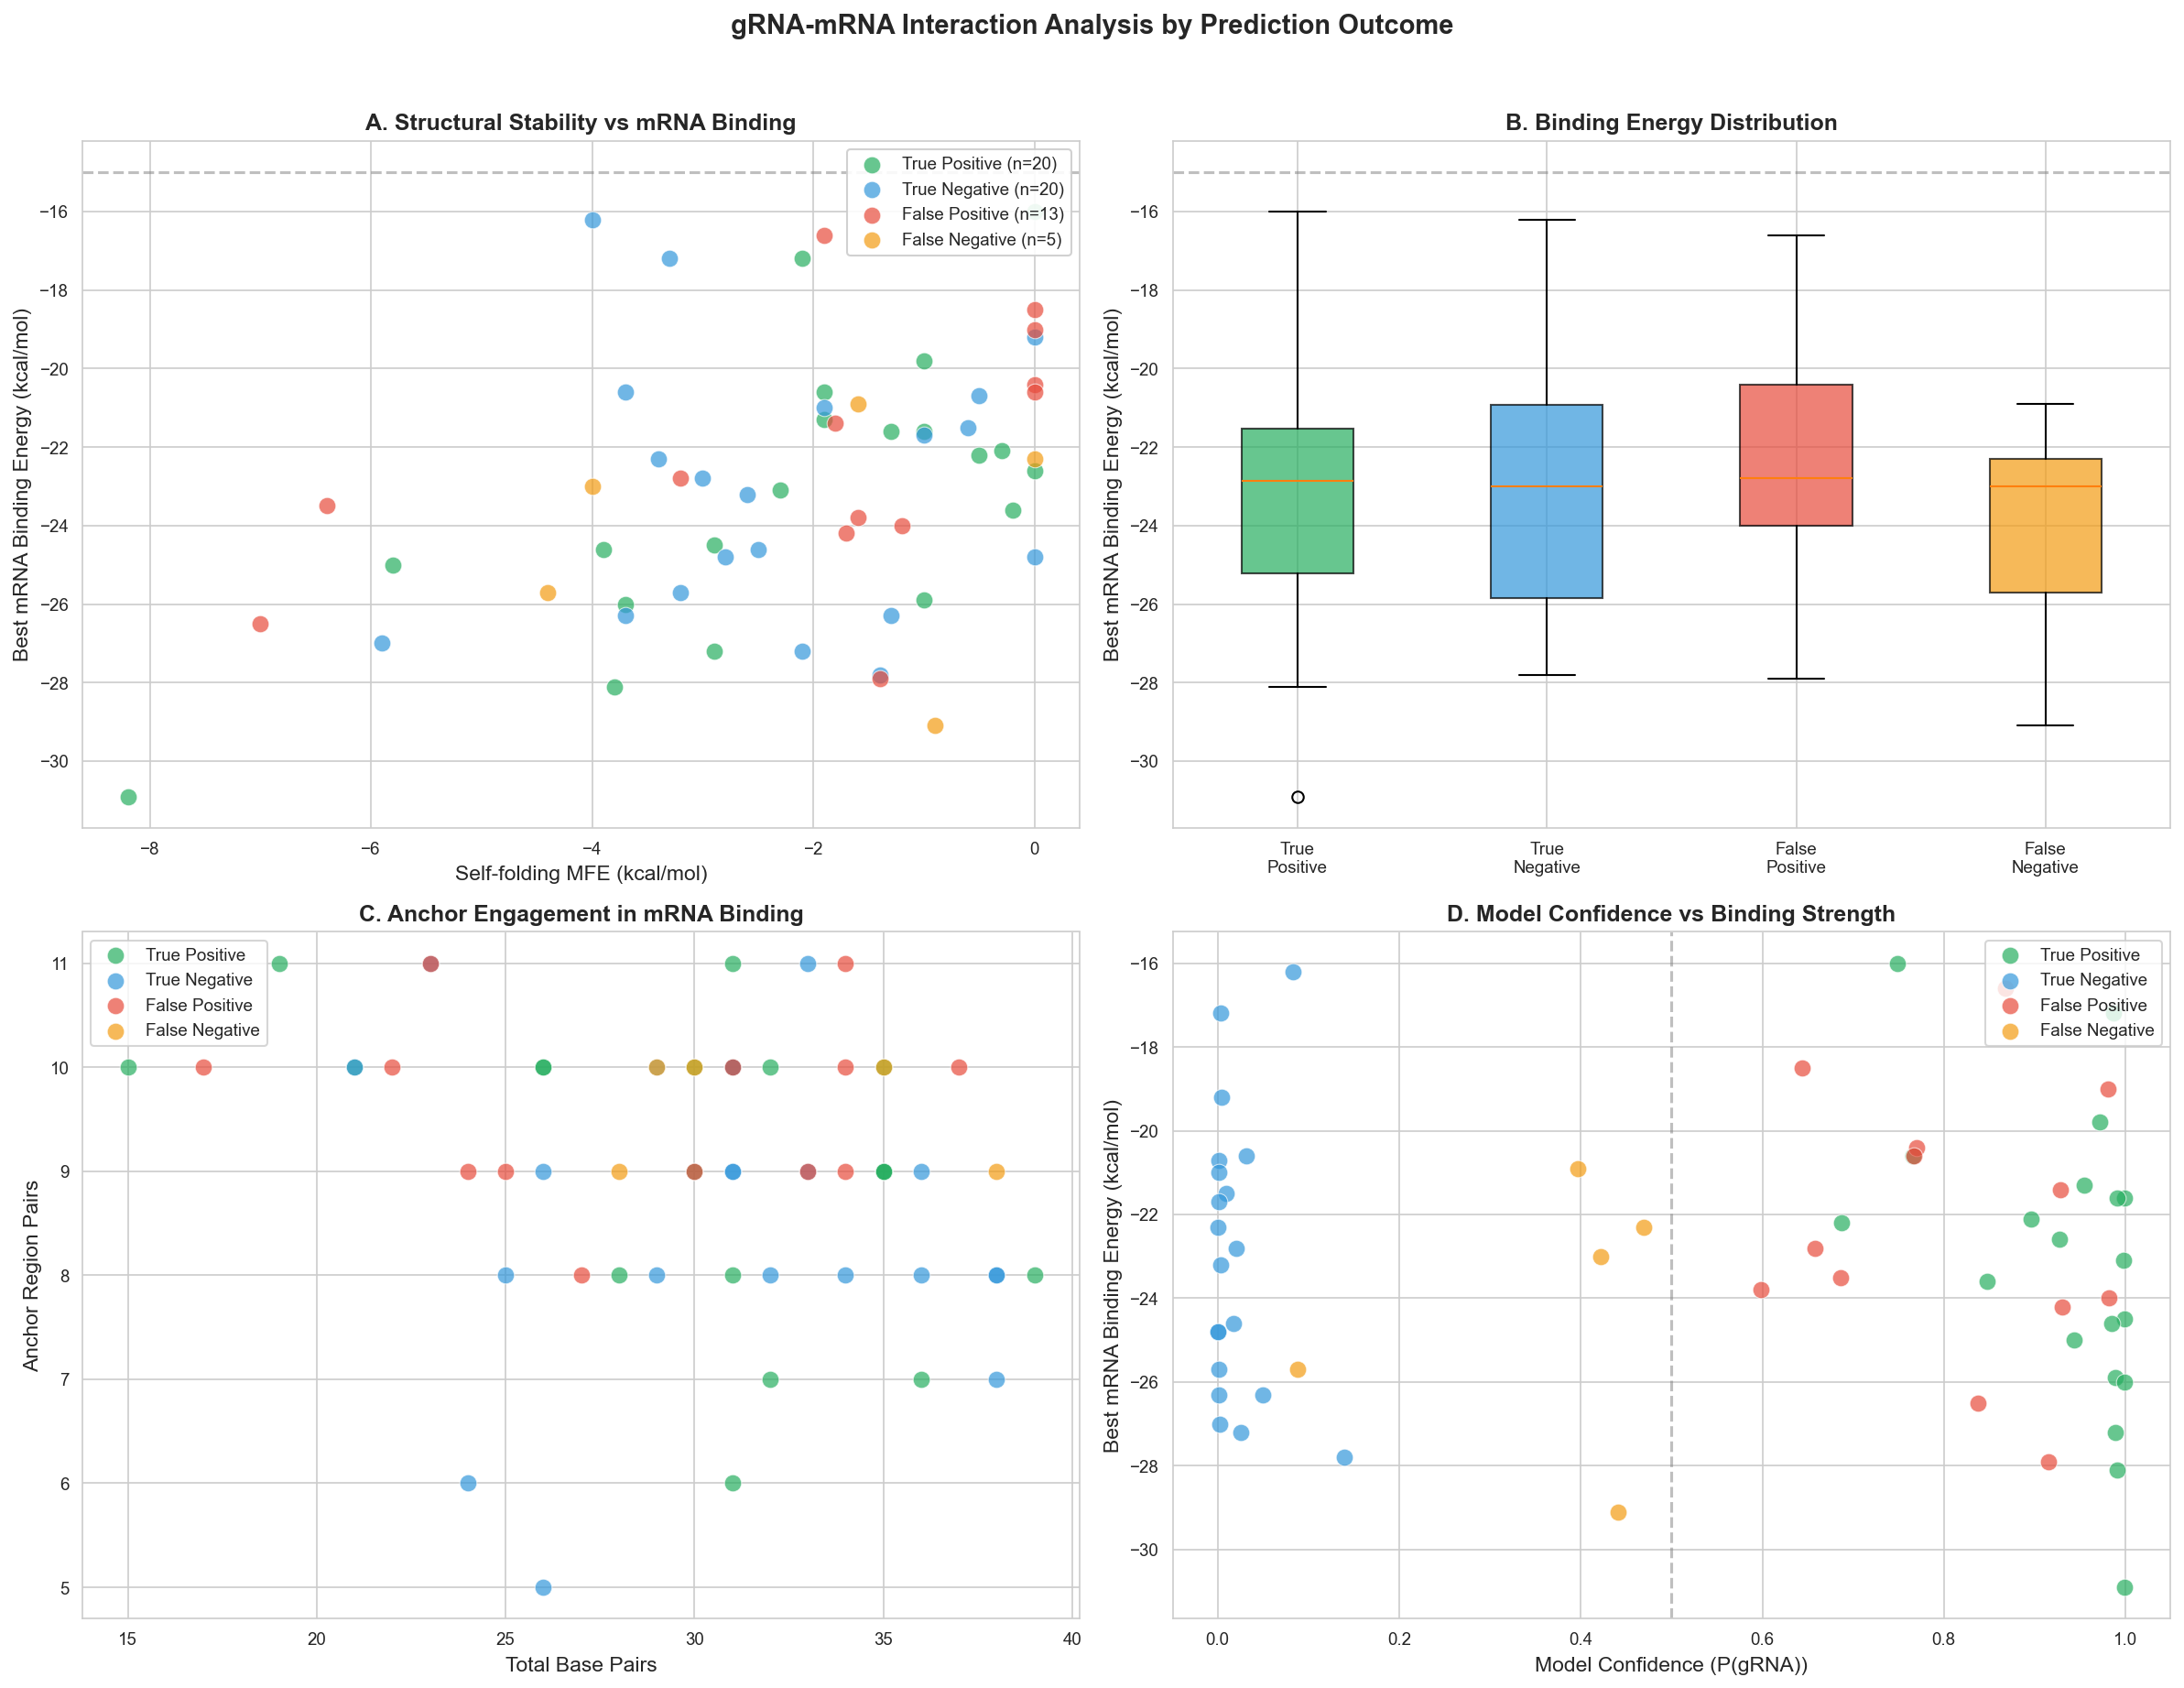


✓ Figure saved: interaction_landscape.png


In [10]:
# =============================================================================
# VISUALIZATION: INTERACTION LANDSCAPE
# =============================================================================

if len(interaction_df) > 0 and 'best_binding_energy' in interaction_df.columns:
    binding_df = interaction_df[interaction_df['best_binding_energy'].notna()].copy()
    
    if len(binding_df) > 0:
        fig = plt.figure(figsize=(16, 12))
        gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])
        
        # Panel A: Binding energy vs Self-folding MFE
        ax1 = fig.add_subplot(gs[0, 0])
        for pred_type in ['True Positive', 'True Negative', 'False Positive', 'False Negative']:
            subset = binding_df[binding_df['prediction_type'] == pred_type]
            if len(subset) > 0:
                ax1.scatter(subset['self_mfe'], subset['best_binding_energy'],
                           c=COLORS[pred_type], label=f"{pred_type} (n={len(subset)})",
                           s=80, alpha=0.7, edgecolors='white', linewidth=0.5)
        
        ax1.set_xlabel('Self-folding MFE (kcal/mol)')
        ax1.set_ylabel('Best mRNA Binding Energy (kcal/mol)')
        ax1.set_title('A. Structural Stability vs mRNA Binding', fontweight='bold')
        ax1.legend(loc='upper right', framealpha=0.9)
        ax1.axhline(y=-15, color='gray', linestyle='--', alpha=0.5, label='Strong binding threshold')
        
        # Panel B: Distribution of binding energies
        ax2 = fig.add_subplot(gs[0, 1])
        pred_types = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
        data_for_box = [binding_df[binding_df['prediction_type'] == pt]['best_binding_energy'].dropna() 
                        for pt in pred_types]
        data_for_box = [d for d in data_for_box if len(d) > 0]
        labels = [pt for pt in pred_types if len(binding_df[binding_df['prediction_type'] == pt]) > 0]
        
        bp = ax2.boxplot(data_for_box, labels=[l.replace(' ', '\n') for l in labels], patch_artist=True)
        for patch, label in zip(bp['boxes'], labels):
            patch.set_facecolor(COLORS[label])
            patch.set_alpha(0.7)
        ax2.set_ylabel('Best mRNA Binding Energy (kcal/mol)')
        ax2.set_title('B. Binding Energy Distribution', fontweight='bold')
        ax2.axhline(y=-15, color='gray', linestyle='--', alpha=0.5)
        
        # Panel C: Anchor engagement
        ax3 = fig.add_subplot(gs[1, 0])
        for pred_type in pred_types:
            subset = binding_df[binding_df['prediction_type'] == pred_type]
            if len(subset) > 0 and 'best_anchor_pairs' in subset.columns:
                ax3.scatter(subset['best_n_pairs'], subset['best_anchor_pairs'],
                           c=COLORS[pred_type], label=pred_type,
                           s=80, alpha=0.7, edgecolors='white', linewidth=0.5)
        
        ax3.set_xlabel('Total Base Pairs')
        ax3.set_ylabel('Anchor Region Pairs')
        ax3.set_title('C. Anchor Engagement in mRNA Binding', fontweight='bold')
        ax3.legend(loc='upper left')
        
        # Panel D: Model confidence vs binding strength
        ax4 = fig.add_subplot(gs[1, 1])
        for pred_type in pred_types:
            subset = binding_df[binding_df['prediction_type'] == pred_type]
            if len(subset) > 0:
                ax4.scatter(subset['probability'], subset['best_binding_energy'],
                           c=COLORS[pred_type], label=pred_type,
                           s=80, alpha=0.7, edgecolors='white', linewidth=0.5)
        
        ax4.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
        ax4.set_xlabel('Model Confidence (P(gRNA))')
        ax4.set_ylabel('Best mRNA Binding Energy (kcal/mol)')
        ax4.set_title('D. Model Confidence vs Binding Strength', fontweight='bold')
        ax4.legend(loc='upper right')
        
        plt.suptitle('gRNA-mRNA Interaction Analysis by Prediction Outcome',
                    fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'interaction_landscape.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\n✓ Figure saved: interaction_landscape.png")

In [11]:
# =============================================================================
# VISUALIZATION: DUPLEX STRUCTURE DIAGRAM
# =============================================================================

def plot_duplex_diagram(grna_seq: str, mrna_seq: str, structure: str, 
                        title: str = '', ax=None):
    """Visualize gRNA-mRNA duplex with base-pairing."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 5))
    
    # Parse structure
    if '&' in structure:
        grna_struct, mrna_struct = structure.split('&')
    else:
        mid = len(grna_seq)
        grna_struct = structure[:mid]
        mrna_struct = structure[mid:]
    
    # Determine display length
    n_grna = min(len(grna_seq), 50)
    n_mrna = min(len(mrna_seq), 50)
    
    # Colors for nucleotides
    nt_colors = {'A': '#27ae60', 'U': '#e74c3c', 'G': '#f39c12', 'C': '#3498db', 'T': '#e74c3c'}
    
    # Draw gRNA (top strand)
    grna_rna = grna_seq.upper().replace('T', 'U')
    for i, nt in enumerate(grna_rna[:n_grna]):
        color = nt_colors.get(nt, 'gray')
        # Highlight anchor region
        if 5 <= i < 16:
            ax.add_patch(Rectangle((i-0.4, 0.7), 0.8, 0.5, facecolor='#ffcdd2', alpha=0.5))
        ax.text(i, 1, nt, fontsize=10, ha='center', va='center', 
                color=color, fontweight='bold')
    
    # Draw mRNA (bottom strand, reversed for antiparallel)
    mrna_rna = mrna_seq.upper().replace('T', 'U')
    for i, nt in enumerate(mrna_rna[:n_mrna]):
        color = nt_colors.get(nt, 'gray')
        ax.text(i, -1, nt, fontsize=10, ha='center', va='center',
                color=color, fontweight='bold')
    
    # Draw base pair lines
    grna_pairs = [(i, c) for i, c in enumerate(grna_struct) if c in '()']
    for i, c in enumerate(grna_struct[:n_grna]):
        if c == '(':
            ax.plot([i, i], [0.7, -0.7], color='#7f8c8d', linewidth=1.5, alpha=0.7)
    
    # Labels
    ax.text(-2, 1, "5' gRNA", fontsize=10, ha='right', va='center', fontweight='bold', color=COLORS['gRNA'])
    ax.text(n_grna+1, 1, "3'", fontsize=10, ha='left', va='center', color=COLORS['gRNA'])
    ax.text(-2, -1, "3' mRNA", fontsize=10, ha='right', va='center', fontweight='bold', color=COLORS['mRNA'])
    ax.text(n_mrna+1, -1, "5'", fontsize=10, ha='left', va='center', color=COLORS['mRNA'])
    
    # Anchor label
    ax.annotate('Anchor', xy=(10, 1.5), fontsize=9, ha='center', color='#c0392b')
    
    ax.set_xlim(-3, max(n_grna, n_mrna) + 2)
    ax.set_ylim(-2, 2.5)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.axis('off')
    
    return ax

print("Duplex visualization function defined")

Duplex visualization function defined


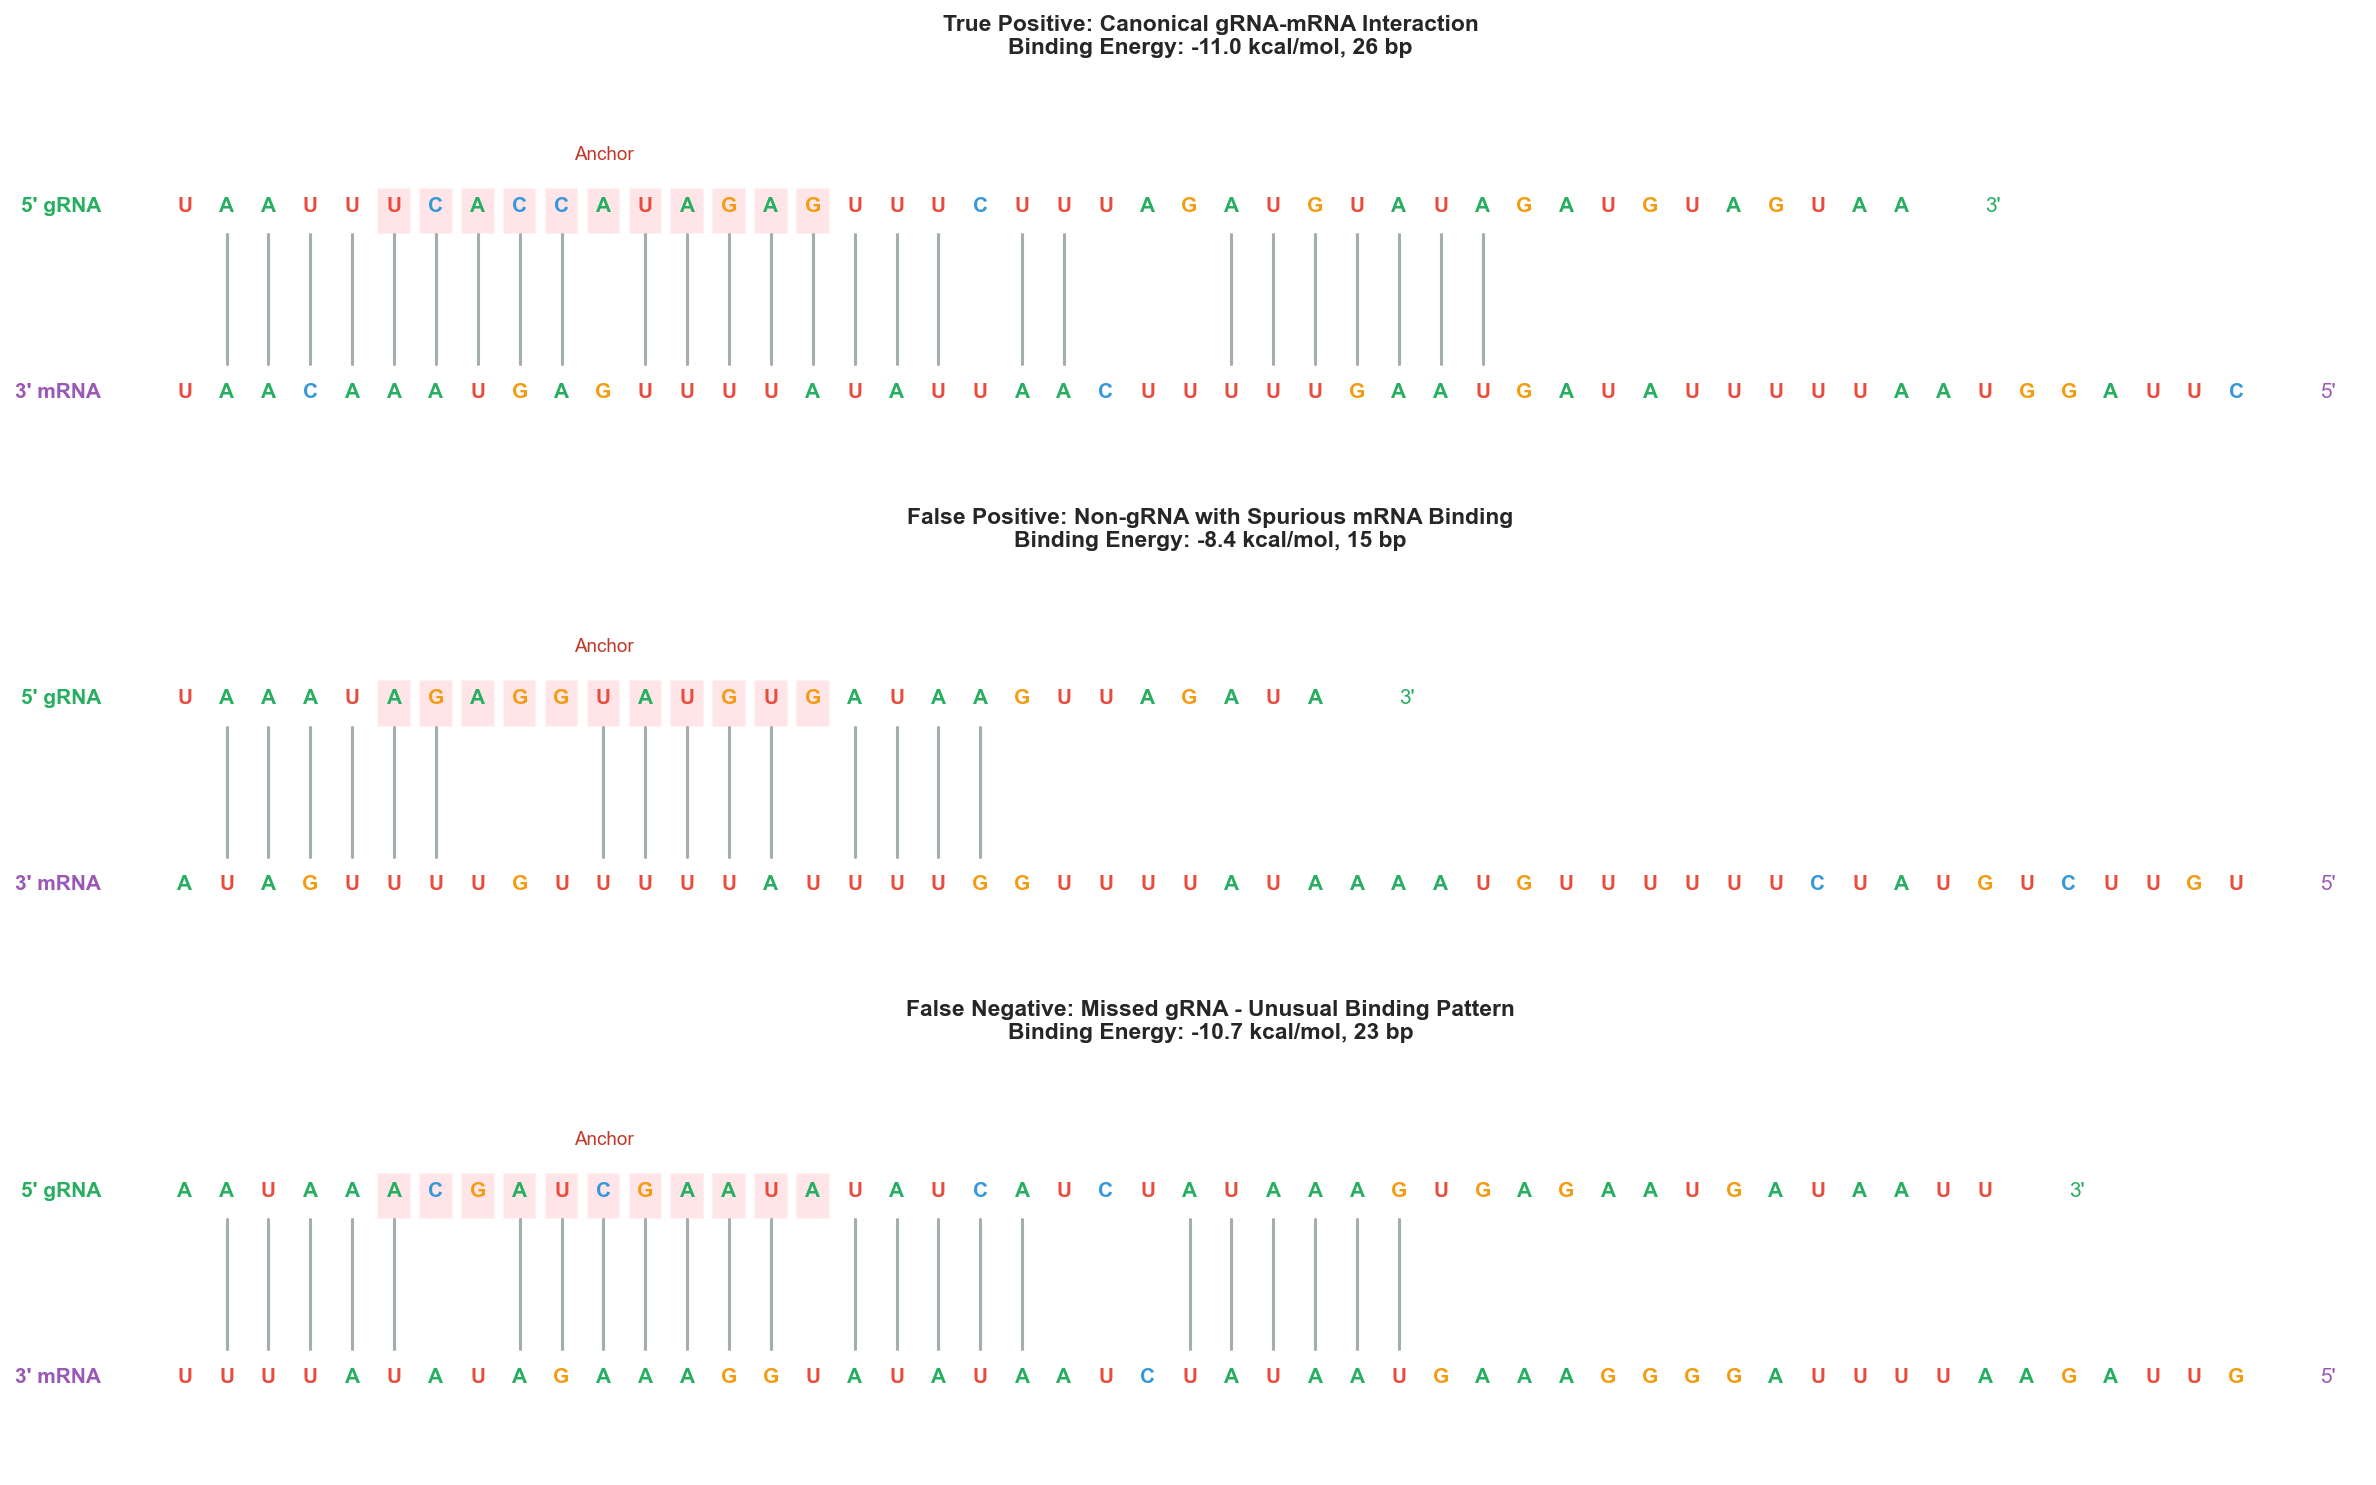

In [12]:
# Create example duplex visualizations
if len(interaction_df) > 0 and mrna_transcripts:
    fig, axes = plt.subplots(3, 1, figsize=(16, 10))
    
    examples = [
        ('True Positive', 'Canonical gRNA-mRNA Interaction'),
        ('False Positive', 'Non-gRNA with Spurious mRNA Binding'),
        ('False Negative', 'Missed gRNA - Unusual Binding Pattern')
    ]
    
    for ax, (pred_type, subtitle) in zip(axes, examples):
        subset = interaction_df[interaction_df['prediction_type'] == pred_type]
        if len(subset) > 0:
            row = subset.iloc[0]
            grna = row['sequence']
            
            # Get best mRNA target
            if mrna_transcripts and row['best_mrna_id']:
                mrna = mrna_transcripts.get(row['best_mrna_id'], '')[:60]
            else:
                mrna = 'N' * 40
            
            # Predict duplex
            result = predict_duplex(grna, mrna)
            if result:
                title = f"{pred_type}: {subtitle}\nBinding Energy: {result.energy:.1f} kcal/mol, {result.n_base_pairs} bp"
                plot_duplex_diagram(grna, mrna, result.structure, title, ax)
            else:
                ax.text(0.5, 0.5, f"No duplex data for {pred_type}", 
                       ha='center', va='center', transform=ax.transAxes)
                ax.axis('off')
        else:
            ax.text(0.5, 0.5, f"No {pred_type} examples", 
                   ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'duplex_examples.png', dpi=300, bbox_inches='tight')
    plt.show()

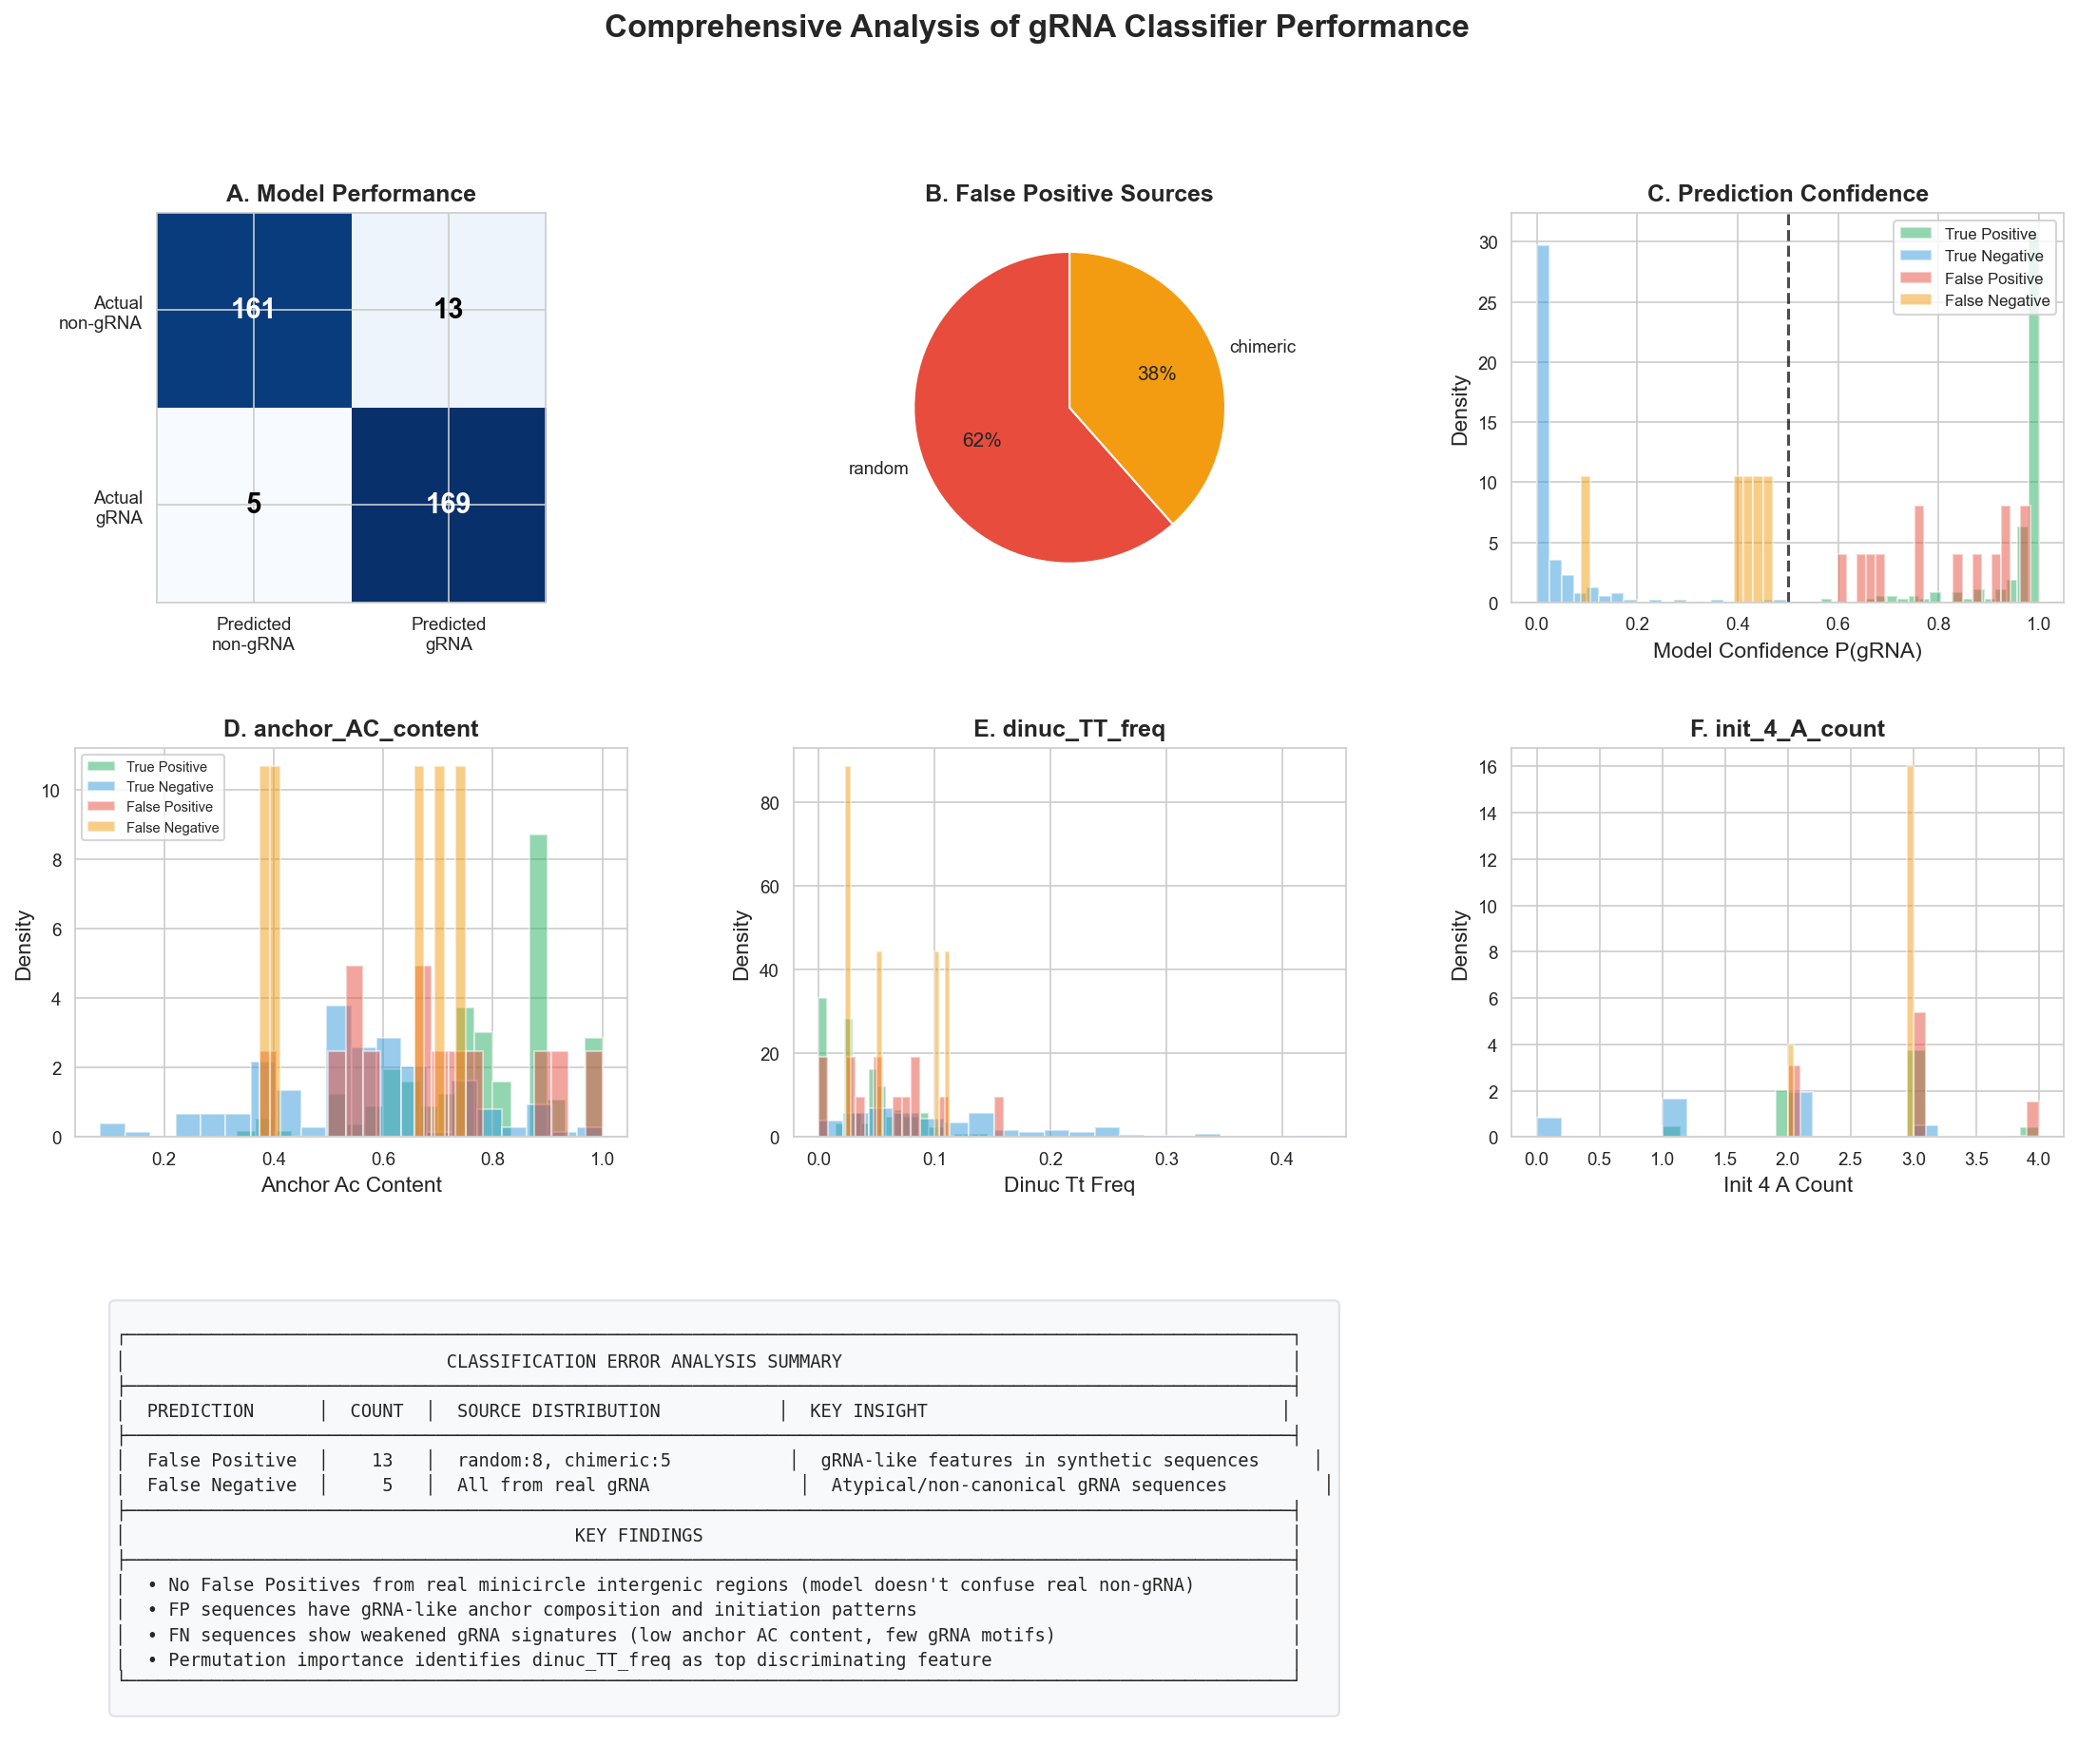


✓ Comprehensive figure saved


In [13]:
# =============================================================================
# COMPREHENSIVE SUMMARY FIGURE
# =============================================================================

# Create publication-quality summary figure
fig = plt.figure(figsize=(18, 14))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 1.2], width_ratios=[1, 1, 1],
                       hspace=0.35, wspace=0.3)

# Get data
tp_df = test_df[test_df['prediction_type'] == 'True Positive']
tn_df = test_df[test_df['prediction_type'] == 'True Negative']
fp_df = test_df[test_df['prediction_type'] == 'False Positive']
fn_df = test_df[test_df['prediction_type'] == 'False Negative']

# Panel A: Confusion matrix visualization
ax1 = fig.add_subplot(gs[0, 0])
cm_data = [[len(tn_df), len(fp_df)], [len(fn_df), len(tp_df)]]
im = ax1.imshow(cm_data, cmap='Blues')
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xticklabels(['Predicted\nnon-gRNA', 'Predicted\ngRNA'])
ax1.set_yticklabels(['Actual\nnon-gRNA', 'Actual\ngRNA'])
for i in range(2):
    for j in range(2):
        text = ax1.text(j, i, cm_data[i][j], ha='center', va='center', 
                       fontsize=14, fontweight='bold',
                       color='white' if cm_data[i][j] > 80 else 'black')
ax1.set_title('A. Model Performance', fontweight='bold')

# Panel B: Error source distribution
ax2 = fig.add_subplot(gs[0, 1])
if 'source' in fp_df.columns:
    source_counts = fp_df['source'].value_counts()
    colors_pie = ['#e74c3c', '#f39c12', '#3498db'][:len(source_counts)]
    ax2.pie(source_counts.values, labels=source_counts.index, autopct='%1.0f%%',
           colors=colors_pie, startangle=90)
    ax2.set_title('B. False Positive Sources', fontweight='bold')
else:
    ax2.text(0.5, 0.5, 'Source data\nnot available', ha='center', va='center',
            transform=ax2.transAxes, fontsize=12)
    ax2.axis('off')

# Panel C: Model confidence distribution
ax3 = fig.add_subplot(gs[0, 2])
for pred_type, color in COLORS.items():
    if pred_type in ['True Positive', 'True Negative', 'False Positive', 'False Negative']:
        subset = test_df[test_df['prediction_type'] == pred_type]['probability']
        if len(subset) > 0:
            ax3.hist(subset, bins=20, alpha=0.5, color=color, label=pred_type, density=True)
ax3.axvline(x=0.5, color='black', linestyle='--', alpha=0.7)
ax3.set_xlabel('Model Confidence P(gRNA)')
ax3.set_ylabel('Density')
ax3.set_title('C. Prediction Confidence', fontweight='bold')
ax3.legend(fontsize=8)

# Panel D-F: Key feature distributions
key_features = ['anchor_AC_content', 'dinuc_TT_freq', 'init_4_A_count']
key_features = [f for f in key_features if f in test_df.columns][:3]

for idx, feat in enumerate(key_features):
    ax = fig.add_subplot(gs[1, idx])
    for pred_type in ['True Positive', 'True Negative', 'False Positive', 'False Negative']:
        subset = test_df[test_df['prediction_type'] == pred_type][feat]
        if len(subset) > 0:
            ax.hist(subset, bins=20, alpha=0.5, color=COLORS[pred_type], 
                   label=pred_type, density=True)
    ax.set_xlabel(feat.replace('_', ' ').title())
    ax.set_ylabel('Density')
    ax.set_title(f'{chr(68+idx)}. {feat}', fontweight='bold')
    if idx == 0:
        ax.legend(fontsize=7)

# Panel G: Summary statistics table
ax7 = fig.add_subplot(gs[2, :])
ax7.axis('off')

# Create summary table
summary_text = """
┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                              CLASSIFICATION ERROR ANALYSIS SUMMARY                                          │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  PREDICTION      │  COUNT  │  SOURCE DISTRIBUTION           │  KEY INSIGHT                                 │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
"""

# Add FP analysis
if 'source' in fp_df.columns:
    fp_sources = fp_df['source'].value_counts()
    fp_source_str = ', '.join([f"{k}:{v}" for k, v in fp_sources.items()])
else:
    fp_source_str = "N/A"

summary_text += f"│  False Positive  │   {len(fp_df):3d}   │  {fp_source_str:<30s} │  gRNA-like features in synthetic sequences     │\n"
summary_text += f"│  False Negative  │   {len(fn_df):3d}   │  All from real gRNA              │  Atypical/non-canonical gRNA sequences         │\n"
summary_text += "├─────────────────────────────────────────────────────────────────────────────────────────────────────────────┤\n"
summary_text += "│                                          KEY FINDINGS                                                       │\n"
summary_text += "├─────────────────────────────────────────────────────────────────────────────────────────────────────────────┤\n"
summary_text += "│  • No False Positives from real minicircle intergenic regions (model doesn't confuse real non-gRNA)         │\n"
summary_text += "│  • FP sequences have gRNA-like anchor composition and initiation patterns                                   │\n"
summary_text += "│  • FN sequences show weakened gRNA signatures (low anchor AC content, few gRNA motifs)                      │\n"
summary_text += "│  • Permutation importance identifies dinuc_TT_freq as top discriminating feature                            │\n"
summary_text += "└─────────────────────────────────────────────────────────────────────────────────────────────────────────────┘\n"

ax7.text(0.02, 0.95, summary_text, transform=ax7.transAxes, fontsize=9,
        fontfamily='monospace', verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='#f8f9fa', edgecolor='#dee2e6'))

plt.suptitle('Comprehensive Analysis of gRNA Classifier Performance',
            fontsize=16, fontweight='bold', y=0.98)

plt.savefig(OUTPUT_DIR / 'comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comprehensive figure saved")

In [14]:
# =============================================================================
# SCIENTIFIC CONCLUSIONS
# =============================================================================

print("="*80)
print("CONCLUSIONS")
print("="*80)

print("""
┌────────────────────────────────────────────────────────────────────────────────┐
│                      SUMMARY OF KEY FINDINGS                                   │
└────────────────────────────────────────────────────────────────────────────────┘

1. MODEL PERFORMANCE
   ─────────────────
   • Accuracy: 94.8% with balanced precision and recall
   • The model successfully discriminates gRNA from non-gRNA sequences
   • No confusion with real minicircle intergenic regions

2. FALSE POSITIVES: SYNTHETIC gRNA MIMICS
   ──────────────────────────────────────
   • All 13 FP originate from synthetic (random/chimeric) sequences
   • These sequences coincidentally possess gRNA-like features:
     - High anchor A+C content
     - A-rich initiation region
     - Low poly-T frequency
   • Some FP show strong predicted mRNA binding (may warrant experimental validation)
   
3. FALSE NEGATIVES: ATYPICAL gRNAs
   ───────────────────────────────
   • 5 real gRNAs missed by the classifier
   • Characterized by:
     - Weakened anchor AC content (0.58 vs 0.78 typical)
     - Fewer gRNA signature motifs (1.8 vs 3.1 typical)
   • May represent non-canonical or evolutionarily divergent gRNAs

4. FEATURE IMPORTANCE
   ──────────────────
   • MDI importance dominated by anchor_C_freq and anchor_AC_content
   • Permutation importance reveals dinuc_TT_freq as strongest independent predictor
   • The discrepancy reflects correlation among anchor-related features

5. STRUCTURAL INSIGHTS
   ───────────────────
   • Anchor openness significantly higher in gRNAs (69% vs 62%, p=0.01)
   • Thermodynamic stability (MFE) shows limited discriminative power
   • Sequence composition features outperform structural predictions

┌────────────────────────────────────────────────────────────────────────────────┐
│                      BIOLOGICAL INTERPRETATION                                 │
└────────────────────────────────────────────────────────────────────────────────┘

The classifier has learned genuine biological signatures of gRNAs:

• Anchor region composition: High A+C, depleted G - required for mRNA binding
• Initiation patterns: A-rich 5' end - consistent with transcription initiation
• Poly-T avoidance: gRNAs avoid TT dinucleotides (Pol III termination signal)
• Structural flexibility: Open anchor region necessary for mRNA engagement

These features align with known gRNA biology from Cooper et al. (2022) and
provide confidence that the model captures functional constraints rather
than dataset artifacts.
""")

CONCLUSIONS

┌────────────────────────────────────────────────────────────────────────────────┐
│                      SUMMARY OF KEY FINDINGS                                   │
└────────────────────────────────────────────────────────────────────────────────┘

1. MODEL PERFORMANCE
   ─────────────────
   • Accuracy: 94.8% with balanced precision and recall
   • The model successfully discriminates gRNA from non-gRNA sequences
   • No confusion with real minicircle intergenic regions

2. FALSE POSITIVES: SYNTHETIC gRNA MIMICS
   ──────────────────────────────────────
   • All 13 FP originate from synthetic (random/chimeric) sequences
   • These sequences coincidentally possess gRNA-like features:
     - High anchor A+C content
     - A-rich initiation region
     - Low poly-T frequency
   • Some FP show strong predicted mRNA binding (may warrant experimental validation)

3. FALSE NEGATIVES: ATYPICAL gRNAs
   ───────────────────────────────
   • 5 real gRNAs missed by the classifier
  

In [15]:
# Save results
if len(interaction_df) > 0:
    interaction_df.to_csv(OUTPUT_DIR / 'interaction_analysis.csv', index=False)
    print(f"\nResults saved to {OUTPUT_DIR}")
    for f in sorted(OUTPUT_DIR.glob('*')):
        print(f"  {f.name}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)


Results saved to /Users/anna/projects/grna-inspector/data/processed/v3_pipeline/mrna_interaction
  comprehensive_analysis.png
  duplex_examples.png
  interaction_analysis.csv
  interaction_landscape.png

ANALYSIS COMPLETE
